<a href="https://www.kaggle.com/code/emmalytle/synthetic-clustering-of-endometriosis-symptoms?scriptVersionId=300842887" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Abstract:**
This notebook explores synthetic endometriosis patient data by extracting the most frequent patterns of patient clusters that appear when using variable normalization and different supervised & unsupervised learning models. 

These exploratory methods are used to find representations of patient phenotypes with common features and symptoms associated with endometriosis, rather than focusing on diagnosis or making clinical claims. We treat diagnosis as a noisy proxy, not ground truth, because endometriosis is underdiagnosed and labels encode access and bias as much as biology.

This dataset cannot be used to estimate true prevalence, but instead, view our methods and approach as a sandbox for methods: testing clustering approaches, visualization strategies, and framing of underdiagnosis questions before moving to real EHR or registry data.


# **Key Findings:**
* 5 clinical phenotypes identified; correlate with symptom‑based phenotypes, such as:
    * Classic symptomatic
    * Infertility‑dominant
    * Menstrual‑only
    * Hormone‑only
    * Low‑symptom
* Diagnosis rates differ across these phenotypes, with some high‑symptom groups still showing substantial non‑diagnosed proportions.
* Significant differences across clusters for:
    * Menstrual Irregularity, Hormone Abnormality, and Infertility, with (p < 0.001)
* No significant differences for:
    * Age, BMI, Chronic Pain Level
* Dense “ribbons” in parallel categories and overlapping “clouds” in PCA show that risk is more about combinations of symptoms than any single variable.
* Age range of 35-44 is the most commonly found group across multiple versions of clustering, followed closely by 25-34. This reflects the dataset’s design and highlights that symptom phenotypes span the peak reproductive years.
* In this synthetic cohort:
    * Infertility is relatively uncommon, despite being found in [25-50% of infertile women](https://pmc.ncbi.nlm.nih.gov/articles/PMC2941592/), and in 30-50% of women with endometriosis.
    * High BMI wasn't a common factor, despite [weight-based stigmatization](https://journalofethics.ama-assn.org/article/weight-bias-health-care/2010-04) being reported as a common experience.


# **Motivation and Project Framing:**
Endometriosis is a multi-faceted problem, and the real-world issues we’re looking to contribute to with this research, and beyond, involve:
* Shortening the time between long diagnostic delays
* Shining light on underdiagnosis populations
* Highlighting heterogeneity in endometriosis presentation

We treat this notebook as Phase 0 of a larger research program that views endometriosis as a system of diseases rather than a single entity, using symptom-based clusters here as a scaffold for future integration with comorbidity and molecular data in order to better tackle these real-world issues.

Instead of asking “Can we predict diagnosis?”, we ask “What symptom constellations exist, and which of them appear systematically underdiagnosed in this synthetic setting?”


# **Dataset Overview:**
***Source:***

[Endometriosis Dataset](https://www.kaggle.com/datasets/michaelanietie/endometriosis-dataset/data) by [Anietie Michael Jackson](https://www.kaggle.com/michaelanietie)

***Dataset Description:***

This dataset contains 10,000 instances of synthetic but realistic data aimed at aiding research and development in predicting and understanding endometriosis. It is structured to reflect common features and symptoms associated with the condition, making it suitable for training machine learning models. The dataset ensures logical relationships among features to improve model interpretability and predictive power.

***Features:***
* Age: (18–50 years)
* Menstrual_Irregularity: (0 = No, 1 = Yes)
* Chronic_Pain_Level: (0 = None, 10 = Severe)
* Hormone_Level_Abnormality: (0 = Normal, 1 = Abnormal)
* Infertility: (0 = No, 1 = Yes)
* BMI: Body Mass Index (15 to 40)
* Diagnosis: (0 = No endometriosis, 1 = Endometriosis present)


# **Limitations & Ethical, Methodological Caveats:**
* The data is synthetic, but constructed with realistic relationships.
* This is not a diagnostic tool and should not guide individual care decisions, estimate true prevalence, real-world effect sizes, or causal relationships.
* Patterns may or may not mirror real-world populations; any apparent signal is contingent on how the dataset creator encoded relationships.
* We treat diagnosis as a secondary lens, not as “ground truth endometriosis,” to avoid learning health system biases.
* In order to fully treat endometriosis as a full system of interactions, these methodologies would benefit from additional layers of symptom data, like GI symptoms, dyspareunia, and other comorbidities.


# **Tools & Methods Used:**
***Tools & Libraries:***
* PythonPandasScikit-learn
* XGBoostSHAP (for explainability)
* SciPy (statistical testing)
* Matplotlib (visualization)

***Supervised Learning:***
* XGBoost Classifier
* Stratified 5-Fold Cross-Validation
* Threshold tuning (0.35)
* Calibration analysis

XGBoost Classification model was used to predict endometriosis diagnosis. To ensure stability and avoid overfitting, we applied stratified 5-fold cross-validation. Since this is a screening-oriented problem within this synthetic dataset, we adjusted the decision threshold to 0.35, tuning to prioritize recall (minimizing missed cases). 

Probability calibration analysis was performed using a Brier Score of 0.237 and reliability curve to evaluate whether predicted probabilities reflect actual risk, indicating there was mild overestimation at higher predicted probabilities.

***Cross-Validation Performance (Mean ± Std):***
* Precision: 0.454 ± 0.003
* Recall: 0.880 ± 0.009
* F1-score: 0.599 ± 0.004
* ROC-AUC: 0.640 ± 0.013
  

********

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from pathlib import Path

DATA_PATH = Path("/kaggle/input/datasets/michaelanietie/endometriosis-dataset/structured_endometriosis_data.csv")

def main():
    df = pd.read_csv(DATA_PATH)

    X = df.drop(columns=["Diagnosis"])
    y = df["Diagnosis"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric="logloss",
        random_state=42
    )

    model.fit(X_train, y_train)

    
    y_prob = model.predict_proba(X_test)[:, 1]

    threshold = 0.35
    y_pred = (y_prob >= threshold).astype(int)

    print("\nClassification Report (XGBoost)")
    print(classification_report(y_test, y_pred))

    auc = roc_auc_score(y_test, y_prob)
    print(f"ROC-AUC: {auc:.4f}")

main()


Classification Report (XGBoost)
              precision    recall  f1-score   support

           0       0.77      0.25      0.38      1184
           1       0.45      0.89      0.60       816

    accuracy                           0.51      2000
   macro avg       0.61      0.57      0.49      2000
weighted avg       0.64      0.51      0.47      2000

ROC-AUC: 0.6386


In [2]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from xgboost import XGBClassifier

def main():
    df = pd.read_csv(DATA_PATH)

    X = df.drop(columns=["Diagnosis"])
    y = df["Diagnosis"]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []
    recalls = []
    f1s = []
    aucs = []

    threshold = 0.35

    fold_num = 1
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

        model = XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=pos_weight,
            eval_metric="logloss",
            random_state=42
        )

        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]

        y_pred = (y_prob >= threshold).astype(int)

        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        auc = roc_auc_score(y_test, y_prob)

        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        aucs.append(auc)

        print(f"\n Fold {fold_num} ")
        print(f"Precision (class 1): {prec:.3f}")
        print(f"Recall (class 1):    {rec:.3f}")
        print(f"F1-score (class 1):  {f1:.3f}")
        print(f"ROC-AUC:             {auc:.3f}")
        fold_num += 1
    print("\n5-Fold Cross-Validation Summary")
    print(f"Threshold used: {threshold}")

    def mean_std(arr):
        return np.mean(arr), np.std(arr)

    p_mean, p_std = mean_std(precisions)
    r_mean, r_std = mean_std(recalls)
    f_mean, f_std = mean_std(f1s)
    a_mean, a_std = mean_std(aucs)

    print(f"Precision: {p_mean:.3f} ± {p_std:.3f}")
    print(f"Recall:    {r_mean:.3f} ± {r_std:.3f}")
    print(f"F1-score:  {f_mean:.3f} ± {f_std:.3f}")
    print(f"ROC-AUC:   {a_mean:.3f} ± {a_std:.3f}")
    
main()


 Fold 1 
Precision (class 1): 0.461
Recall (class 1):    0.899
F1-score (class 1):  0.610
ROC-AUC:             0.653

 Fold 2 
Precision (class 1): 0.448
Recall (class 1):    0.874
F1-score (class 1):  0.593
ROC-AUC:             0.635

 Fold 3 
Precision (class 1): 0.456
Recall (class 1):    0.887
F1-score (class 1):  0.602
ROC-AUC:             0.646

 Fold 4 
Precision (class 1): 0.462
Recall (class 1):    0.886
F1-score (class 1):  0.608
ROC-AUC:             0.653

 Fold 5 
Precision (class 1): 0.446
Recall (class 1):    0.864
F1-score (class 1):  0.589
ROC-AUC:             0.611

5-Fold Cross-Validation Summary
Threshold used: 0.35
Precision: 0.455 ± 0.006
Recall:    0.882 ± 0.012
F1-score:  0.600 ± 0.008
ROC-AUC:   0.640 ± 0.016



Calibration Results
Brier Score (lower is better): 0.2369
ROC-AUC: 0.6386


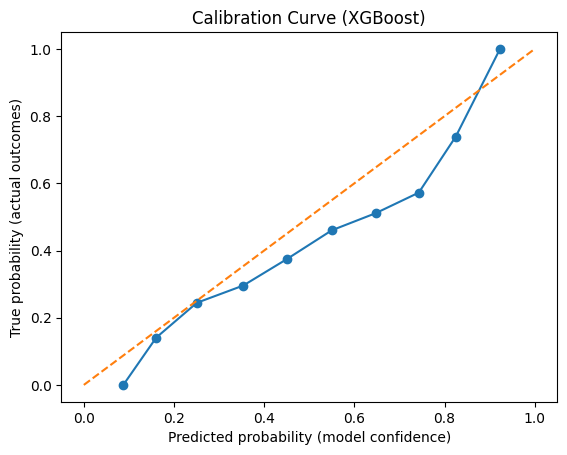

In [3]:
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score

def main():
    df = pd.read_csv(DATA_PATH)
    X = df.drop(columns=["Diagnosis"])
    y = df["Diagnosis"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    model = XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric="logloss",
        random_state=42
    )

    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    brier = brier_score_loss(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    print("\nCalibration Results")
    print(f"Brier Score (lower is better): {brier:.4f}")
    print(f"ROC-AUC: {auc:.4f}")

    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")  
    plt.xlabel("Predicted probability (model confidence)")
    plt.ylabel("True probability (actual outcomes)")
    plt.title("Calibration Curve (XGBoost)")
    plt.show()

main()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def main():
    df = pd.read_csv(DATA_PATH)
    X = df.drop(columns=["Diagnosis"])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("\nTrying KMeans with different number of clusters (k)")
    print("k = number of groups the model will create\n")

    results = []
    for k in range(2, 7):  
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)

        results.append((k, sil))
        print(f"k={k} -> Silhouette Score: {sil:.4f}")

    best_k, best_sil = max(results, key=lambda x: x[1])
    print(f"Best k based on silhouette: k={best_k} (score={best_sil:.4f})")

    final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    final_labels = final_kmeans.fit_predict(X_scaled)

    df_with_clusters = df.copy()
    df_with_clusters["Cluster"] = final_labels

    print("\n Cluster Summary (Mean values) ")
    cluster_summary = df_with_clusters.groupby("Cluster").mean(numeric_only=True)
    print(cluster_summary)

    print("\n Cluster Sizes")
    print(df_with_clusters["Cluster"].value_counts().sort_index())

main()


Trying KMeans with different number of clusters (k)
k = number of groups the model will create

k=2 -> Silhouette Score: 0.2014
k=3 -> Silhouette Score: 0.1962
k=4 -> Silhouette Score: 0.1954
k=5 -> Silhouette Score: 0.2282
k=6 -> Silhouette Score: 0.1941
Best k based on silhouette: k=5 (score=0.2282)

 Cluster Summary (Mean values) 
               Age  Menstrual_Irregularity  Chronic_Pain_Level  \
Cluster                                                          
0        33.662679                1.000000            5.037633   
1        33.594659                0.000000            5.015005   
2        33.840293                0.694131            5.061632   
3        33.965318                0.681255            5.054938   
4        33.541123                1.000000            4.994416   

         Hormone_Level_Abnormality  Infertility        BMI  Diagnosis  
Cluster                                                                
0                         1.000000          0.0  22.9736

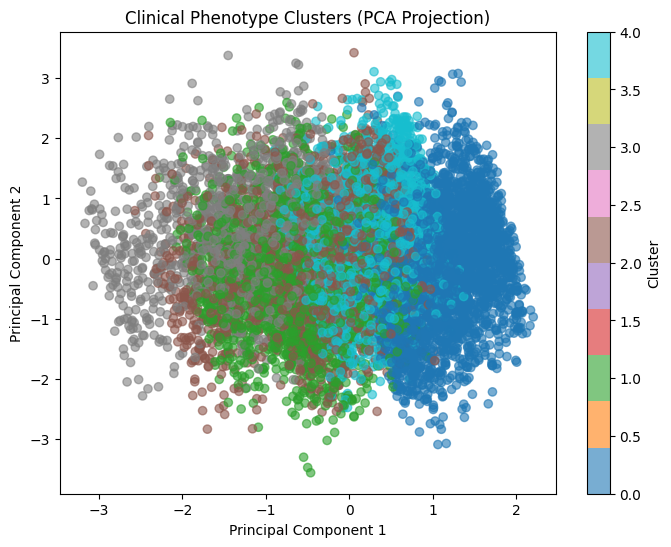

In [5]:
from sklearn.decomposition import PCA

def main():
    df = pd.read_csv(DATA_PATH)
    X = df.drop(columns=["Diagnosis"])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(
        X_pca[:, 0],
        X_pca[:, 1],
        c=labels,
        cmap="tab10",
        alpha=0.6
    )

    plt.title("Clinical Phenotype Clusters (PCA Projection)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, label="Cluster")
    plt.show()

main()

# **Model Evaluation & Visualization Summary:**
* XGBoost achieved moderate discrimination (AUC ~0.64) with high recall at the tuned threshold, but PCA and correlation heatmaps show that the feature space is noisy and weakly linear, which limits simple models.
* K-Means with k=5 yielded statistically distinct phenotypes (significant chi‑square for menstrual irregularity, hormone abnormality, and infertility) that appear as overlapping yet interpretable “clouds” in PCA and as distinct bands in parallel coordinates.
* Calibration analysis and SHAP explainability ensure you treat the model as a structured lens on the synthetic data, not a black‑box decision tool.

***Further Clustering and Visualizations:***

For further clustering of groups beyond those identified using K-Means Clustering, continuous predictors were standardized with StandardScaler so that age, BMI, and pain are on a comparable scale and do not dominate the PCA and clustering procedures. 

Additionally, we defined categorical versions of these predictors by combinatorial symptom patterns, and treated each unique combination of symptom and demographic categories as a patient pathway. Cross-tabulations and contingency tables allow a basic descriptive overview of how common each symptom is and how common it is compared to a diagnosis label. This allows us to see crude associations alongside more complex models.

In order to extract the maximum standardization across variables while avoiding the dilution of data or unfair groupings, we separated the variables that had more than 2 options into ranges as defined by the WHO, CDC, or other government health-related organizations. 

These variables became 4 separate bins per variable:
* [BMI](https://www.who.int/data/gho/data/themes/topics/topic-details/GHO/body-mass-index):
    * Underweight (15 - 19)
    * Average (20 - 25)
    * Overweight (26 - 30)
    * Obese (31-40)
* [Age](https://www.cdc.gov/nchs/hus/sources-definitions/age-adjustment.htm):
    * 18-24
    * 25-34 (Average [child-bearing age](https://www.cdc.gov/nchs/data/nvsr/nvsr74/nvsr74-09.pdf))
    * 35-44 (Pre or perimenopause phase start)
    * 45-50 (Average [menopause](https://medlineplus.gov/menopause.html) start age)
* [Chronic Pain](https://www.hhs.texas.gov/sites/default/files/documents/doing-business-with-hhs/provider-portal/QMP/ZeroToTenPainScale.pdf):
    * No pain: 0
    * Mild pain: 1 - 3
    * Moderate pain: 4 - 6
    * Severe pain: 7-10

By putting these dimensions into bins, we are able to extract larger groups of subtypes, providing more meaningful analysis.

Clusters are reported by these varying symptom profiles:
* 0 = Hormone‑only
    * Hormone Level Abnormality, Menstrual Irregularity
        * (1st - most common profile - 2,926 patients)
* 1 = Low‑symptom
    * (Asymptomatic) OR Hormone Level Abnormality
        * (3rd - common - 2,097 patients)
* 2 = Classic symptomatic
    * (Symptomatic) Hormone Level Abnormality, Menstrual Irregularity, and Infertility OR Hormone Level Abnormality, Infertility
        * (4th - less common - 1,772 patients)
* 3 = Infertility‑dominant
    * Menstrual Irregularity, Infertility OR Infertility
        * (5th - least common profile - 1,211 patients)
 * 4 = Menstrual‑only
    * Menstrual Irregularity
        * (2nd - more common - 1,994 patients)

# **Data Visualization Methods:**

***Frequency Tables and Cross-Tabulations:***
1. All variables, plus the additional K-Means clusters
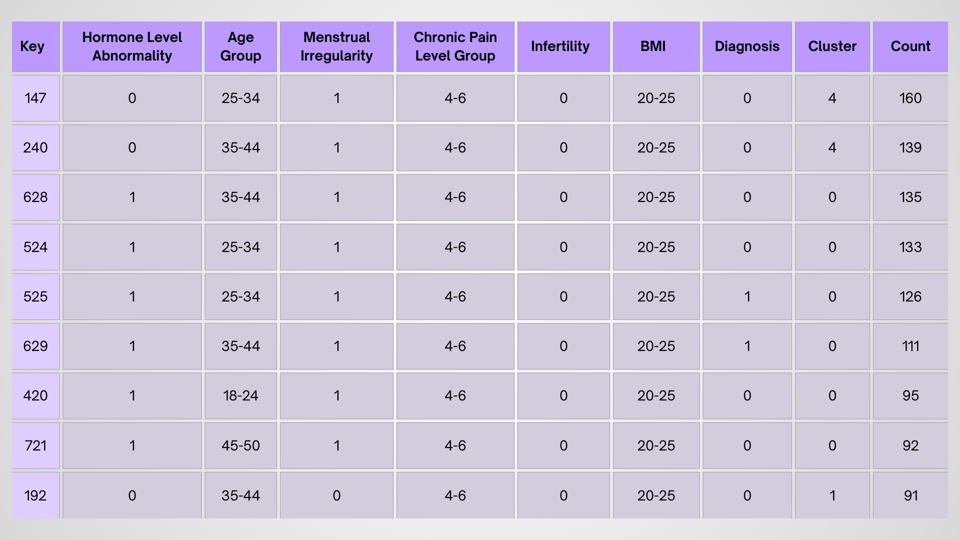
3. Removing diagnosis as a variable:
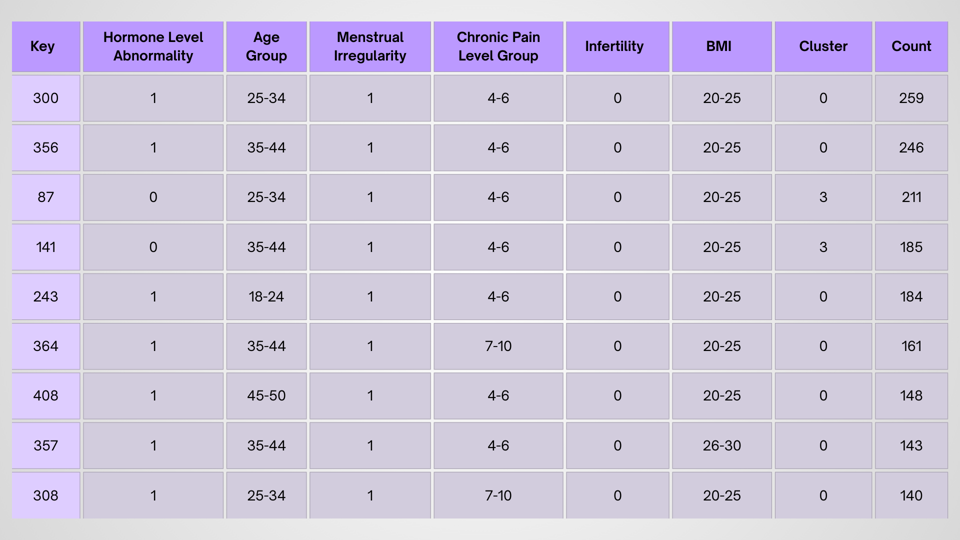
5. Removing variables with no significant difference from the cluster summaries:
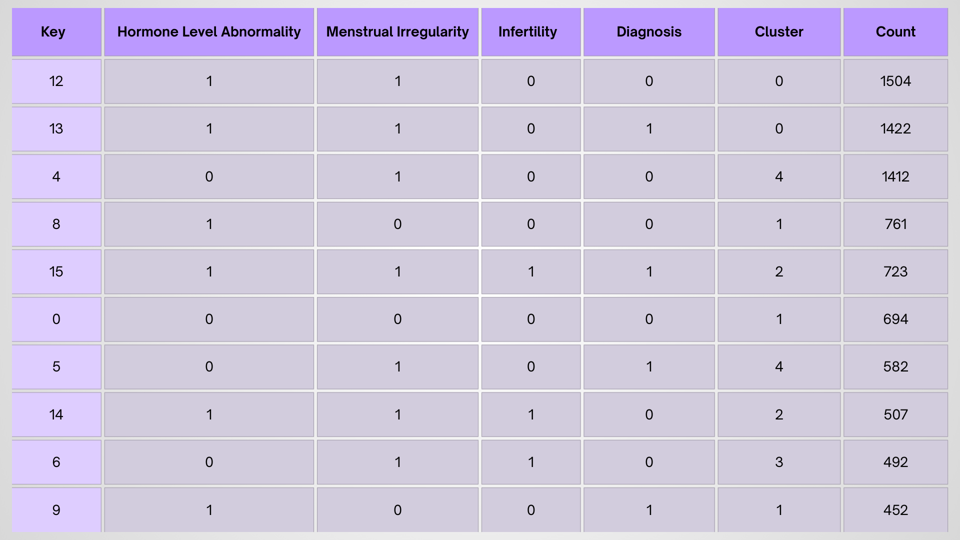
7. Removing age, BMI, chronic pain level, and diagnosis:
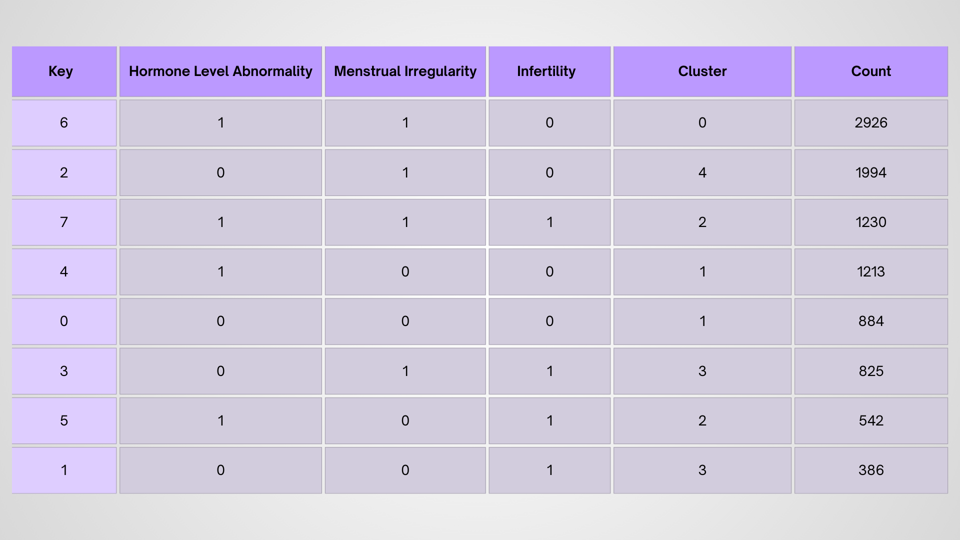

In [6]:
import sys
import os
import seaborn as sns
import sklearn
from pandas.plotting import parallel_coordinates
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

df = pd.read_csv(DATA_PATH)

features = ['Hormone_Level_Abnormality', 'Age', 'Menstrual_Irregularity', 'Chronic_Pain_Level', 'Infertility', 'BMI']

if df is not None:
    x = df[features]
    y = df['Diagnosis']
    x_scaled = StandardScaler().fit_transform(x)
    print("Environment verified. Data loaded and scaled.")
    
df['Age_Group'] = pd.cut(df['Age'], bins=[17, 24, 34, 44, 50], labels=['18-24', '25-34', '35-44', '45-50'])

df['Chronic_Pain_Level_Group'] =  pd.cut(df['Chronic_Pain_Level'], bins=[-1,0,3,6,10], labels=['0', '1-3', '4-6', '7-10']) 

df['BMI_Group'] = pd.cut(df['BMI'], bins=[14, 19, 25, 30, 40], labels=['15-19', '20-25', '26-30', '31-40'])

features_numeric = ['Hormone_Level_Abnormality', 'Age', 'Menstrual_Irregularity', 'Chronic_Pain_Level', 'Infertility', 'BMI', 'Diagnosis']

features_categorical = ['Hormone_Level_Abnormality', 'Age_Group', 'Menstrual_Irregularity', 'Chronic_Pain_Level_Group', 'Infertility', 'BMI_Group', 'Diagnosis']    

dims = ['Hormone_Level_Abnormality', 'Age_Group', 'Menstrual_Irregularity', 'Chronic_Pain_Level_Group', 'Infertility', 'BMI_Group', 'Diagnosis']

pathway_counts = (
    df[dims]
    .astype(str)               
    .groupby(dims)
    .size()
    .reset_index(name='Count')
    .sort_values('Count', ascending=False)
)
print(pathway_counts.head(10))

Environment verified. Data loaded and scaled.
    Hormone_Level_Abnormality Age_Group Menstrual_Irregularity Chronic_Pain_Level_Group Infertility BMI_Group Diagnosis  Count
147                         0     25-34                      1                      4-6           0     20-25         0    160
240                         0     35-44                      1                      4-6           0     20-25         0    139
628                         1     35-44                      1                      4-6           0     20-25         0    135
524                         1     25-34                      1                      4-6           0     20-25         0    133
525                         1     25-34                      1                      4-6           0     20-25         1    126
629                         1     35-44                      1                      4-6           0     20-25         1    111
420                         1     18-24                      1   

***Diagnosis Split Categories***
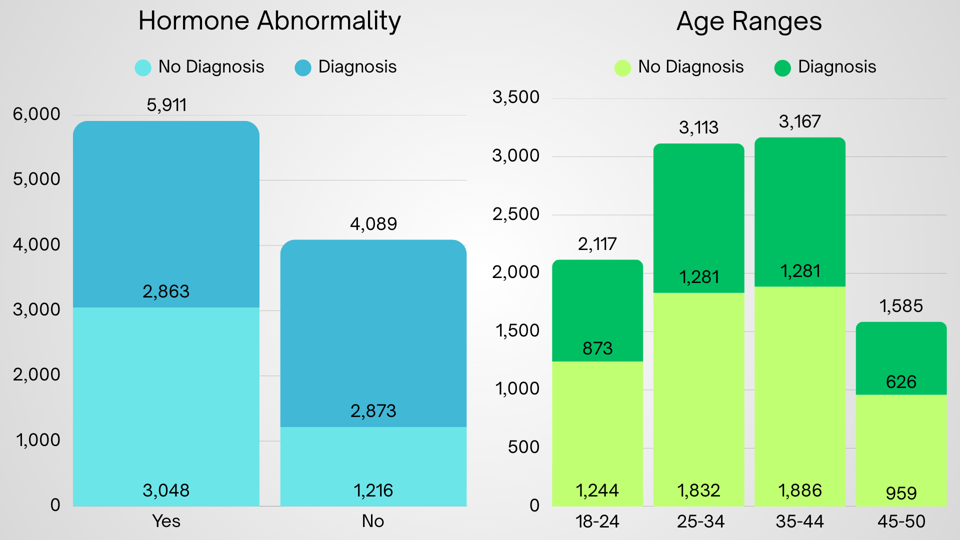
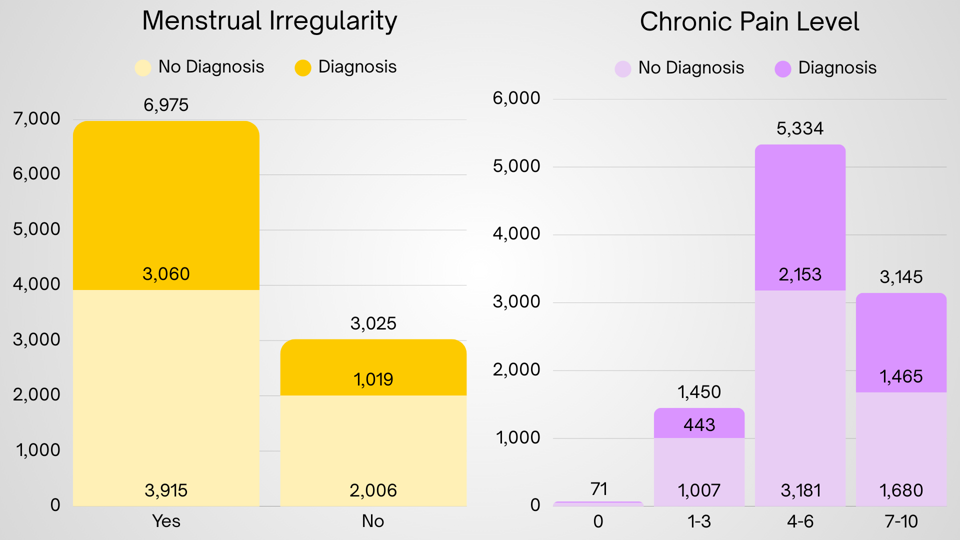
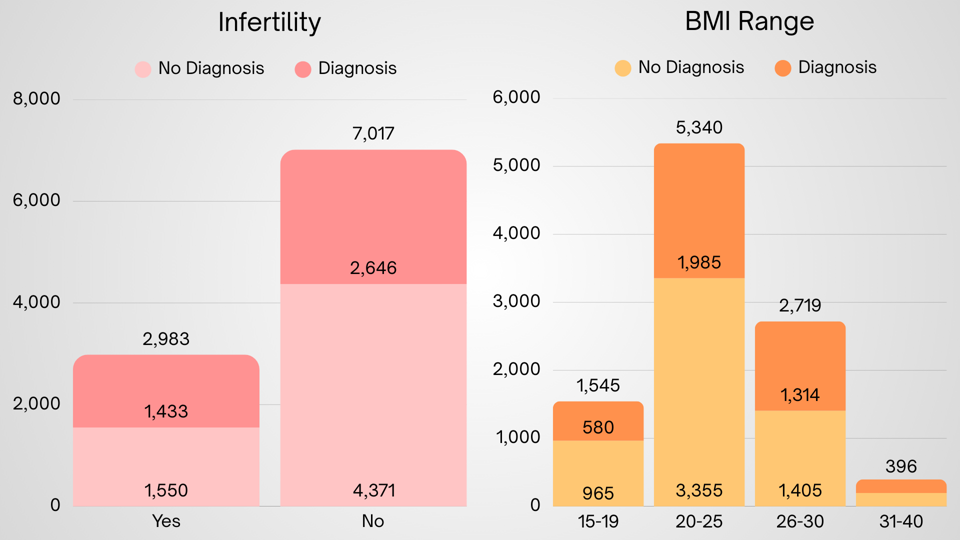
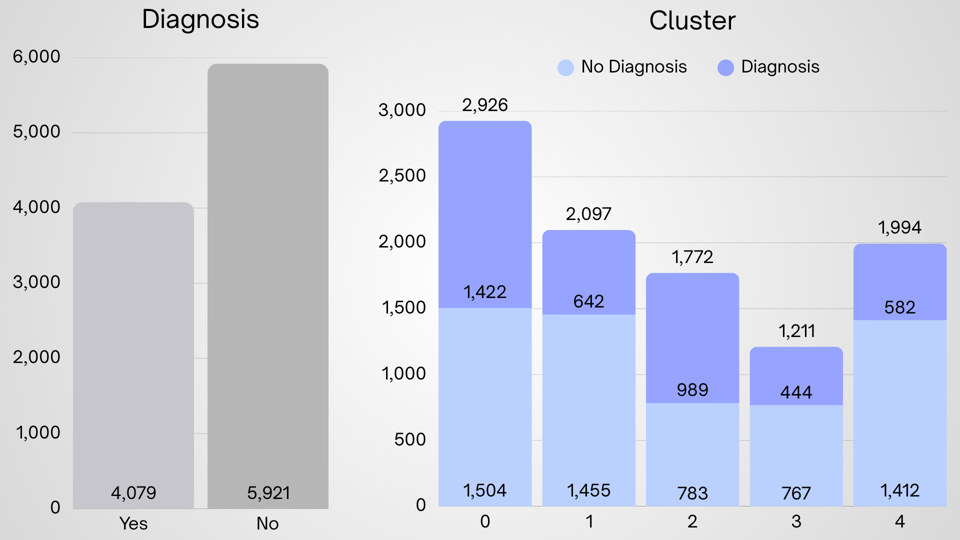


***Parallel Categories***

Shows multi‑dimensional pathways and how clusters/phenotypes move across age, infertility, menstrual irregularity, hormones, and diagnosis. Thick ribbons show common pathways; many high‑symptom pathways split across diagnosis and non‑diagnosis.

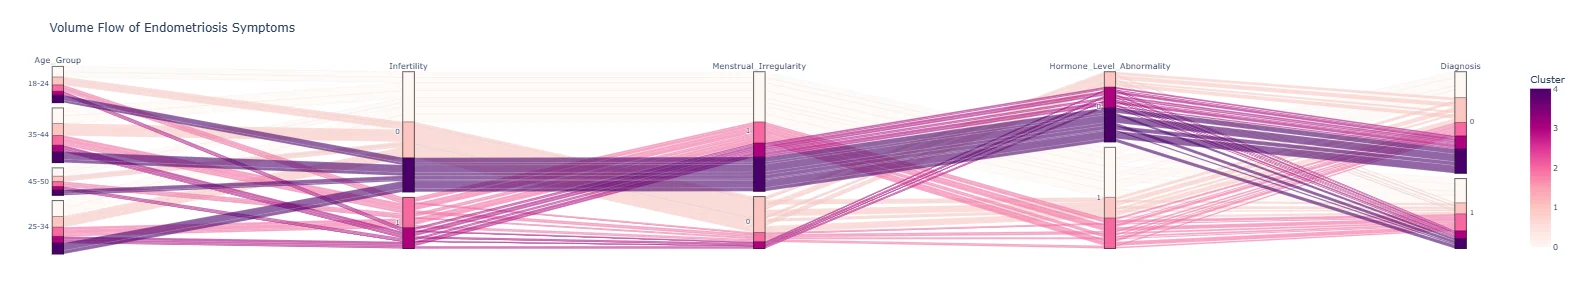

***PCA + Scatterplot/Dimensionality Reduction***

Standardized predictors to reduce the 6-dimension symptom space to 2 components, colored by diagnosis vs. non-diagnosis. In PCA space, diagnosed and control patients largely overlap, and no single linear direction cleanly separates them, motivating non‑linear models.

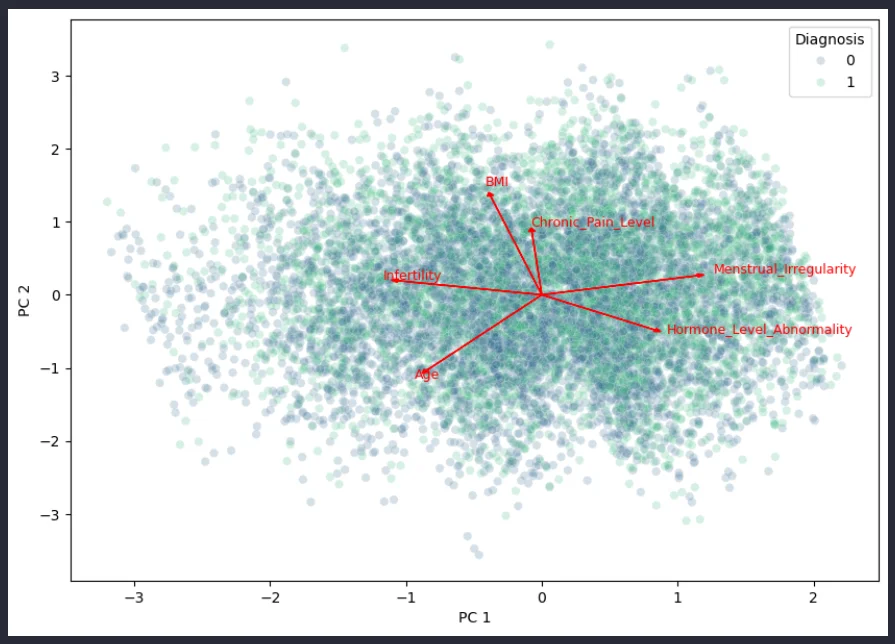

***Correlation Matrix Heatmap***

The cluster label correlates strongly with hormone abnormality and infertility but is weak with age, BMI, and pain, echoing the phenotype definitions.

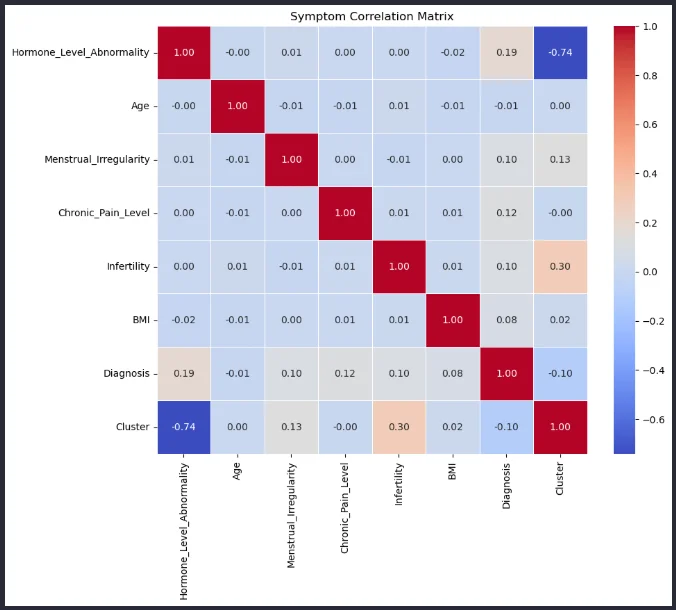

***Violin Plots***

Age spans reproductive years for both groups, and BMI offers little separation, suggesting demographic cutoffs are weak predictors here.

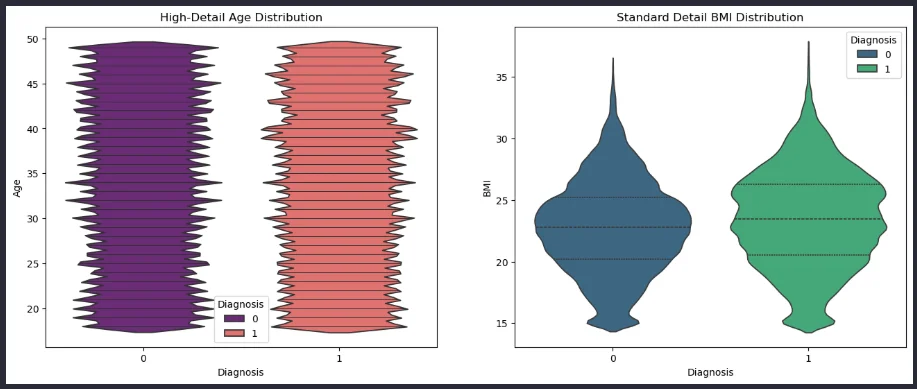

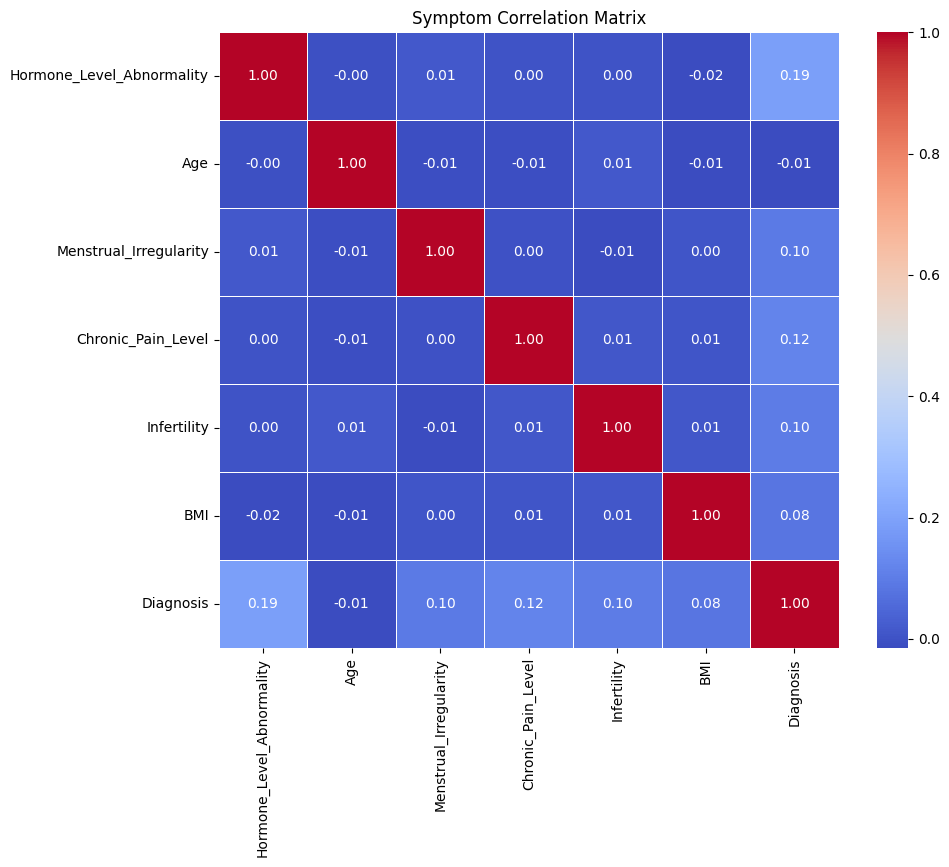

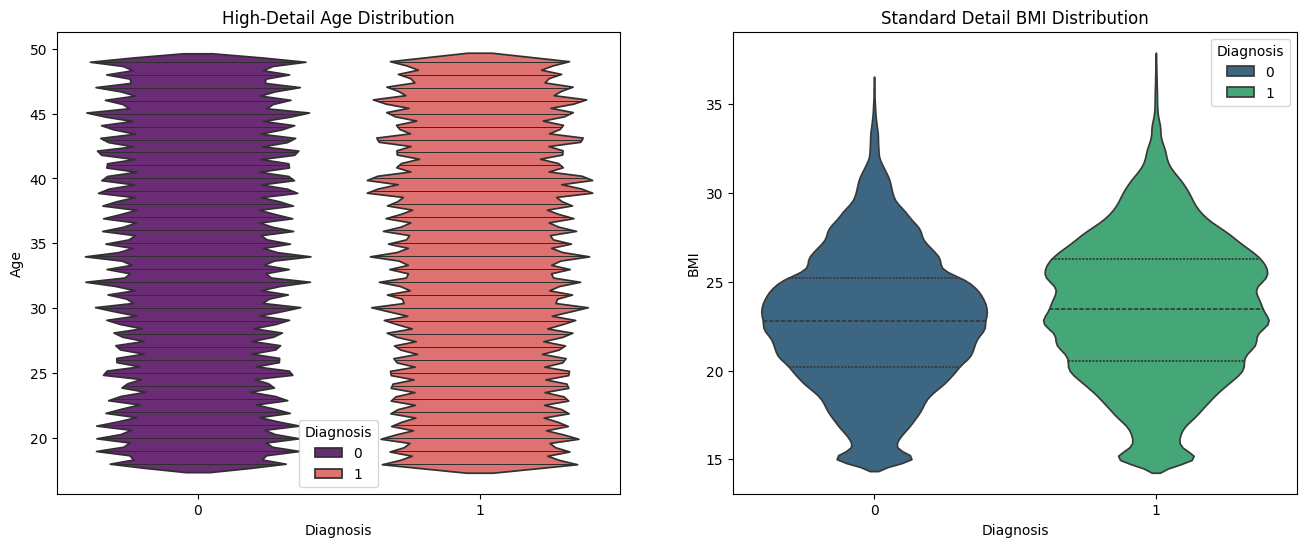

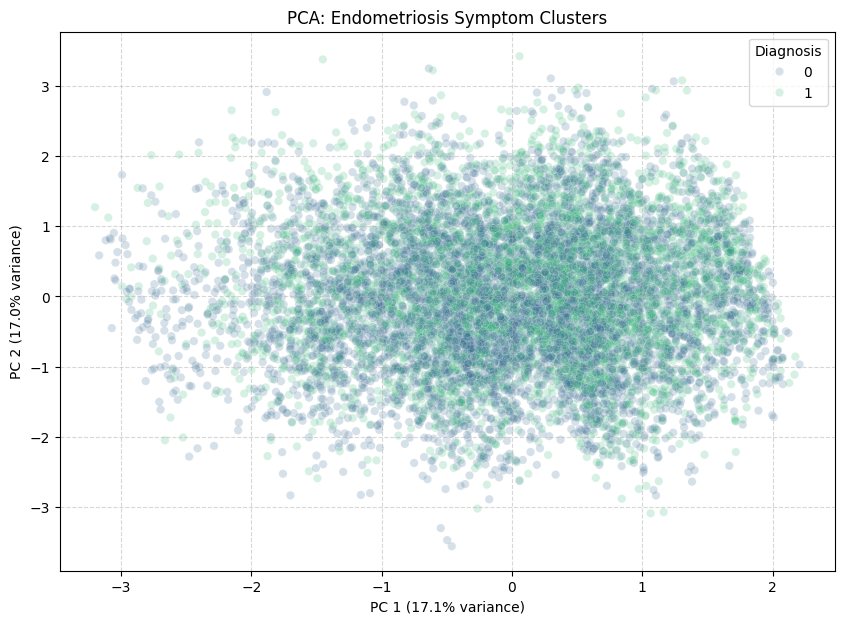

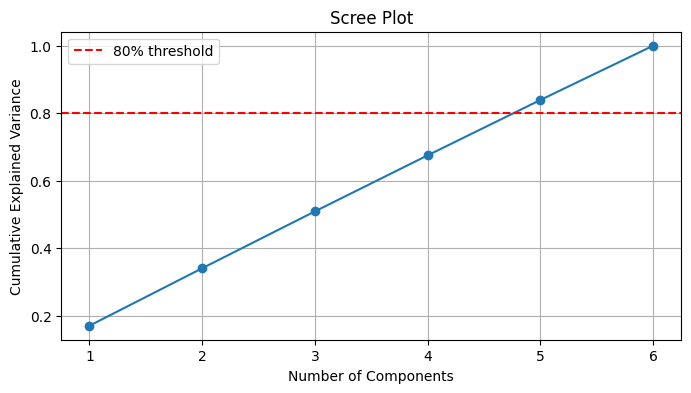

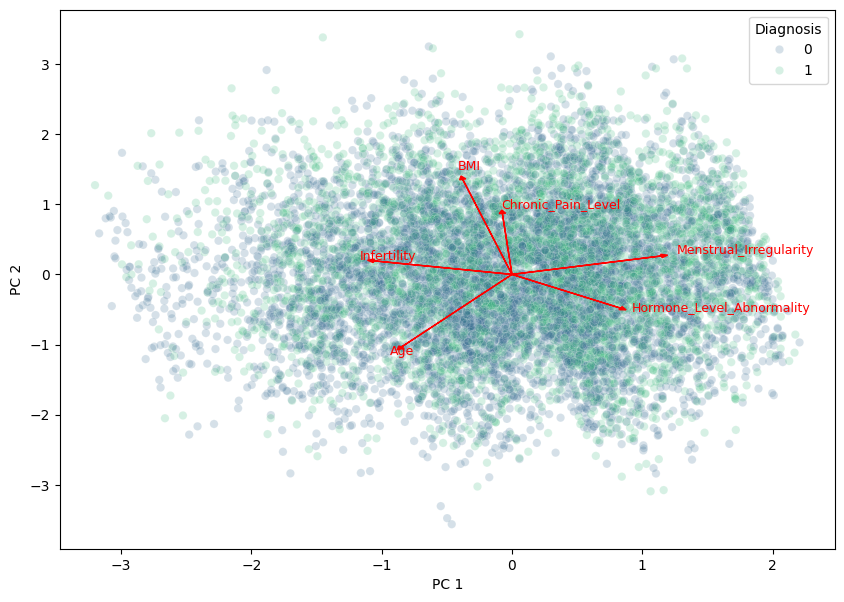

In [7]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.parallel_categories(
    df, 
    dimensions=['Hormone_Level_Abnormality', 'Age_Group', 'Menstrual_Irregularity', 'Chronic_Pain_Level_Group', 'Infertility', 'BMI_Group'],
    color="Diagnosis",
    color_continuous_scale=px.colors.sequential.RdPu,
    title="Volume Flow of Endometriosis Symptoms",
)

fig.show()

plt.figure(figsize=(10, 8))

corr = df[features_numeric].corr() 

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Symptom Correlation Matrix")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.violinplot(x='Diagnosis', y='Age', data=df, ax=ax1, bw_adjust=0.2, inner="stick", hue="Diagnosis", palette="magma")
ax1.set_title("High-Detail Age Distribution")

sns.violinplot(x='Diagnosis', y='BMI', data=df, ax=ax2, bw_adjust=0.5, inner="quart", hue="Diagnosis",palette="viridis")
ax2.set_title("Standard Detail BMI Distribution")

plt.show()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_scaled)

pca_df = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2'])
pca_df['Diagnosis'] = y

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC 1', y='PC 2', hue='Diagnosis', data=pca_df, palette='viridis', alpha=0.2)
plt.title('PCA: Endometriosis Symptom Clusters')
plt.xlabel(f'PC 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

pca_full = PCA(n_components=6)  
pca_full.fit(x_scaled)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 7), pca_full.explained_variance_ratio_.cumsum(), marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='PC 1', y='PC 2', hue='Diagnosis', data=pca_df, 
                palette='viridis', alpha=0.2, ax=ax)

loadings = pca.components_.T 
for i, feature in enumerate(features): 
    ax.arrow(0, 0, loadings[i, 0]*2, loadings[i, 1]*2, head_width=0.05, head_length=0.05, fc='red', ec='red')
    ax.text(loadings[i, 0]*2.2, loadings[i, 1]*2.2, feature, fontsize=9, color='red')


# **Interpretation & Clinical Framing:**
* We interpret clusters as prototype phenotypes in this synthetic space, not validated clinical subtypes.
* The most commonly reported Cluster 0 was identified as “Hormone‑Only Phenotype”, highlighting hormone level abnormalities and menstrual irregularities as the common factors.
* Cluster 1, or “Asymptomatic/Low‑Symptom Phenotype,” correlates to no symptoms, or solely hormone level abnormalities. These phenotypes would benefit from the additional layers of symptom data addressed in our limitations section.
* Cluster 2 is the “Classic Symptomatic Phenotype”, accompanied by hormone level abnormality, menstrual irregularity, and infertility; or hormone level abnormality and infertility
* The least common Cluster 3 is our “Infertility‑Dominant Phenotype”, characterized by menstrual irregularity and Infertility, or just Infertility
* Lastly, Cluster 4 represents our “Menstrual‑Only Phenotype” of solely menstrual irregularity as a symptom.

Diagnosis labels are treated as biased proxies; differences in diagnosis rates across groups are interpreted as potential underdiagnosis patterns, not as proof of who has endometriosis. These patterns motivate future work on real data (symptom + comorbidity clustering).

# **Conclusion:**
Synthetic data, unsupervised clustering, and visual analytics can recover sensible symptom phenotypes and show how underdiagnosis might play out in a controlled environment. We have contributed:
* A transparent pipeline combining Exploratory Data Analysis, supervised risk modeling, and phenotype clustering
* A framing that treats endometriosis as a heterogeneous system of diseases, rather than a single label.

# **Key Takeaways:**
* Diagnosis is only partially aligned with symptom burden; there are large high‑symptom but low‑diagnosis groups, even in this synthetic setting.
* Menstrual irregularity, hormone abnormality, and infertility define clear phenotypes; age, BMI, and pain do not meaningfully separate clusters or strongly correlate with diagnosis on their own.
* Non‑linear models (XGBoost) can separate synthetic labels reasonably well but still reflect label bias and underdiagnosis; they are best used here as risk scorers and pattern microscopes, not clinical tools.
* The combination of clustering, visualization, and model explanations provides a reusable template for exploring endometriosis as a family of subtypes in real‑world datasets.

# **Next Steps & Research Roadmap:**
This analysis is the first step as a team in helping identify groups of relevant patient subtypes and underdiagnosed populations, warranting the use of realistic data using these models and methods to develop further defined clusters of patients, perhaps even identifying distinct phenotypes when used with more robust or complete data. 

Endometriosis affects individuals beyond factors relating to the reproductive system and cycles. By integrating additional data and gathering a fuller patient profile, we can further define these potential subtypes, limiting the time these underdiagnosed individuals spend waiting for treatment.

# **For Researchers & Clinicians:**
If you are working with EHR, claims, or registry data and are interested in phenotype clustering for endometriosis, our team is actively seeking collaborators and data partners.

# **References**
1. [Machine learning in the early detection of endometriosis: a literature review on symptom clustering and imaging integration:](https://pfmjournal.org/journal/view.php?viewtype=pubreader&number=190#!po=31.8182)
2. [Revisiting the Risk Factors for Endometriosis: A Machine Learning Approach](https://pubmed.ncbi.nlm.nih.gov/35887611/)
3. [Pain Phenotypes in Endometriosis: A Population-Based Study Using Latent Class Analysis](https://pubmed.ncbi.nlm.nih.gov/39627905/)
4. [A cellular and molecular portrait of endometriosis subtypes](https://www.biorxiv.org/content/10.1101/2021.05.20.445037v1.full)
5. [Phenotyping Adolescent Endometriosis: Characterizing Symptom Heterogeneity Through Note- and Patient-Level Clustering](https://www.medrxiv.org/content/10.1101/2025.02.10.25321215v1.full)
6. [A Novel Classification of Endometriosis Based on Clusters of Comorbidities](https://www.mdpi.com/2227-9059/11/9/2448#Discussion)
7. [Unveiling endometriosis hidden comorbidities using a data-driven approach: a retrospective matched cohort study](https://www.nature.com/articles/s44294-025-00073-z?fromPaywallRec=false)
8. [Learning endometriosis phenotypes from patient-generated data](https://www.nature.com/articles/s41746-020-0292-9)